In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sentiment140:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2477%2F4140%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240403%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240403T162434Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Ded62c5003c44a9078a8d55fe60fbedf78ad2a950580f6931999a9f4ef76ec0ef299f2f16f7ac66826118c2f8bdd82f119862199ec6fba1eff1d26b7e97f60339da33f7629ae771a5c2bb7b6fb27a8a245aa2dddadc4ba2e238d604c4da35a780095917a48ae7e557724bdb15651a2e326c4dcc00a1bda7532ab3cf37e3c0fda4c27f15e8af694ebc9db24075153987cf41699c77b17973ab40f09014499c37b6f44830ffef9b3a66e45444b186dfefe86ec7e2d824f69981eb964417462a5d9689cd620f2665f492d6ef8ad758c55bbacf807f4f13846d5c3cb4677d95bae53827a6afd5b3ff877617125756abb60fdc93070727fc4b9f33fac3ba4c3481419e,twitter-airline-sentiment:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17%2F742210%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240403%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240403T162434Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3De5e206e734b5b0d30d964f66c6cfbd845e9eb448f7cb65aee3ba275404620709403c008e29e82f9a156f0d26dcbce9c47fc51b0db0018c05a7e2e9e92b531a1151f64954906b4e9cc58119c12a7f7d349a91da618220b2a69b667de191b18298c3a6660f6668e2e932aa0d7a3c2d67bf2623d9b8d862b910aa184e836c55acd14da51a1b70145f1c2cebe3e9b351a81e94a2b2e305a450d3ae4aa5890e50afeb83e94e3b5ae6bab2c53db4672c8509b6eadc6ef258eabfba1b3810946c1d22d905c9cb89a3069c7acd67b166945639e584db9165f14972bd5ab9dacb2ddb536508b6d7ca52ccef80a11bed686d995c91feddd2d4f52e9697f2b3ed7f1a2ef751,amazonreviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1305%2F800230%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240403%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240403T162434Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbb77c5879b59063f35633aa295a66ae11d719f95ee0916c9629e850608921eeba06500da67e2d730c90ebbf4b40abc32492899d3be40ec54e02bbd7cb53bede1922f7614d9340a8551441f1aab5a2b747b4d12cf38770a215d69818628287522d229b8ce00d99ef35d3b9909073403309f841c91d00863fab923160d66a9547ed301243f444bc4e53557006fc109e599ff6d59003f91249772a38d6a7e7f2809a3c5cc34b1088c1231dc3127915ad908ac4b4910d3b0c7e2357e1589bf86ded2597214146b46581dd777fb42c48ac0c1e2a0563ab83866db8bad1ce21b67c386b41ac3ddc533b1f4d5c4a4df1da09e2fc79de0945ef89655e60f5d2e55eceab6,twitter-entity-sentiment-analysis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1520310%2F2510329%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240403%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240403T162434Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D21bcdd057859bb5b880cfeca8da3a8b918f180bfd103d88d9ed0dc8f88456518483151fb3bb01b6f975b47985d0200c2896501433fd1b1e39b5e3eaf0889116d240f68a0b65f54e763149b89289ea131740aacf3f09a529ca1df9cce5b327de6e3be58bcaee8cbd13cb2a7f41a179eecff55a18643bde1ca8806b5d7aa2783c8db1baa75dc946d263dd59c2f131a5b666faa4278acf84544d066efbfece76e425711435b0bb75b27d2d0865db396dad539cbc8404cc6f5acaaaa9060d81972e73918ddad8fe0237e70f3eb22a45eca5c4a09875dd6036dfa28e5daf77f07b724b916e1c17dc62c6914ee6a16ff80214bffccfe2a76bf2f38845f7ca3c5813d9b,emotion-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1590810%2F2617192%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240403%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240403T162434Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db9c693bebac550ee1f2bc5bc5e6f4088027d345240216096c842abe5a3a48cd77c48797ecc4c3c7003684f1d1d52d88f6baf402da5bdacf1ba7423a5d334216603ff21ae619506249f2a5e99f32bb34a484d3beeeef86e233704f1a690862370c85334a727f479a511d6b2bdd4d41058fb26fb59a44b3016ba4a8a4d8c70ffba7693938814ce56f2c700c73000f599bfd3711fa26bde749db941dc9cc90846a210005133f15d4eae046fcffe88c81cd896af7149bdb4bd2acff18fc6327852b08004b802b33eb306a80ab3e01cc3a17230945e3b272469a24b9c93ae17056cf9253334d876b080012fb2c9ecb75dce9f86c71ba46f04e631f1e6d3300081e0f2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 84855679 bytes downloaded
Downloaded and uncompressed: sentiment140
[==================================================] 2678605 bytes downloaded
Downloaded and uncompressed: twitter-airline-sentiment
[==================================================] 517080965 bytes downloaded
Downloaded and uncompressed: amazonreviews
[==================================================] 2090169 bytes downloaded
Downloaded and uncompressed: twitter-entity-sentiment-analysis
[==================================================] 732529 bytes downloaded
Downloaded and uncompressed: emotion-dataset
Data source import complete.


In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


**1.1 LOADING DATASET**

In [ ]:
val_data = pd.read_csv('/kaggle/input/emotion-dataset/validation.csv')
train_data = pd.read_csv('/kaggle/input/emotion-dataset/training.csv')
test_data = pd.read_csv('/kaggle/input/emotion-dataset/test.csv')

In [ ]:
print("Validation data :",val_data.shape)
print("Train data :",train_data.shape)
print("Test data :",test_data.shape)

Validation data : (2000, 2)
Train data : (16000, 2)
Test data : (2000, 2)


In [ ]:
half_test_data = test_data.iloc[1000:]
test_data = test_data.iloc[:1000]

val_data = pd.concat([val_data, half_test_data], axis=0)

print("new Valid data :",val_data.shape)
print("new Test data :",test_data.shape)

new Valid data : (3000, 2)
new Test data : (1000, 2)


In [ ]:
train_data.head(10)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


**1.2 ADDING LABEL DATA**

In [ ]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_data['label_name'] = train_data['label'].map(labels_dict)
train_data.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [ ]:
train_data.groupby(["label_name","label"]).size()

label_name  label
anger       3        2159
fear        4        1937
joy         1        5362
love        2        1304
sadness     0        4666
surprise    5         572
dtype: int64

**1.3 DATA VISUALIZATION**

<Axes: >

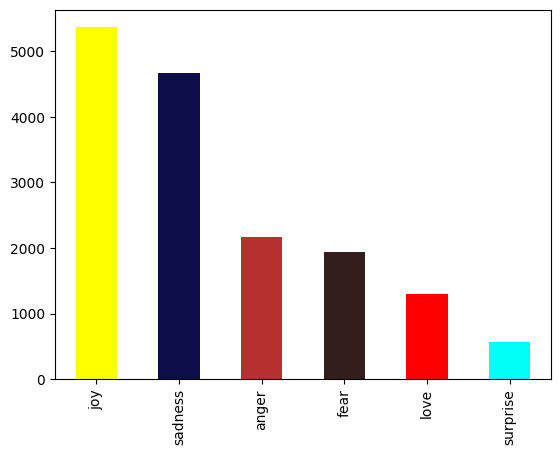

In [ ]:
train_data["label_name"].value_counts().plot(kind='bar',color=['yellow', '#0c0d49', '#b82f2f', '#331e1e', 'red','#00fff7'])

**2**. **DATA** **CLEANING**

In [ ]:
print(train_data.isnull().sum())
print(val_data.isnull().sum())
print(test_data.isnull().sum())

text          0
label         0
label_name    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


**3. *TOKENIZATION* AND STEMMING**

In [ ]:
all_list = train_data['text'].tolist() + test_data['text'].tolist() + val_data['text'].tolist()

In [ ]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(all_list)
word_index1 = tokenizer1.word_index

print("Number of words without Stemming:",len(word_index1))

stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in word_index1.keys()]

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(stemmed_words)
word_index2 = tokenizer2.word_index

print("Number of words with Stemming:",len(word_index2))

Number of words without Stemming: 17096
Number of words with Stemming: 11705


In [ ]:
def preprocess_data(data):
    new_data = []
    for index, row in data.iterrows():
        test_split = row['text'].split()
        stemmed_words2 = [stemmer.stem(word) for word in test_split]
        token_list= tokenizer2.texts_to_sequences([stemmed_words2])[0]
        new_data.append([token_list,row['label']])
    return new_data

In [ ]:
new_train_data = preprocess_data(train_data)
print(train_data['text'][0])
print(new_train_data[0])

i didnt feel humiliated
[[3198, 3265, 220, 665], 0]


In [ ]:
new_val_data = preprocess_data(val_data)
print(val_data['text'][0])
print(new_val_data[0])

im feeling quite sad and sorry for myself but ill snap out of it soon
[[3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380], 0]


In [ ]:
# Splitting into train_X and train_y
train_X = [row[0] for row in new_train_data]
train_y = [row[1] for row in new_train_data]

# Print the results
print("train_X:", train_X[0])
print("train_y:", train_y[0])

train_X: [3198, 3265, 220, 665]
train_y: 0


In [ ]:
val_X = [row[0] for row in new_val_data]
val_y = [row[1] for row in new_val_data]

print("train_X:", val_X[0])
print("train_y:", val_y[0])

train_X: [3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380]
train_y: 0


**3.1 ADD PADDING**

In [ ]:
length_of_longest_sentence = len(max(train_X, key=len))
print(length_of_longest_sentence)
print(max(train_X, key=len))

66
[3198, 613, 3250, 3588, 3217, 3204, 3198, 927, 3245, 1497, 3245, 1354, 3217, 3245, 1303, 1296, 3200, 2107, 1284, 1276, 3220, 220, 3598, 3213, 220, 1276, 3528, 3217, 7890, 4263, 3221, 5569, 1552, 3243, 3198, 4263, 3221, 1552, 5570, 5570, 3198, 3579, 5569, 3198, 7891, 1276, 3200, 3202, 1293, 3219, 1401, 3948, 3598, 3213, 3223, 239, 3528, 3213, 85, 3267, 579, 1658, 3206, 3201, 239, 1289]


In [ ]:
for i in range(len(train_X)):
    for j in range(length_of_longest_sentence-len(train_X[i])):
        train_X[i].append(0)

for i in range(len(val_X)):
    for j in range(length_of_longest_sentence-len(val_X[i])):
        val_X[i].append(0)

**3.2 LIST TO ARRAY(NUMPY)**

In [ ]:
train_X = np.array(train_X)
train_y = np.array(train_y)
val_X = np.array(val_X)
val_y = np.array(val_y)

print(train_X.shape,train_y.shape)
print(val_X.shape,val_y.shape)

(16000, 66) (16000,)
(3000, 66) (3000,)


In [ ]:
# Convert labels to one-hot encoding
train_y_one_hot = to_categorical(train_y, num_classes=16000)
val_y_one_hot = to_categorical(val_y, num_classes=16000)

**4.  CREATE MODEL (LSTM)**

**4.1 BI - LSTM NEURAL NETWORK MODEL TRAINING **

In [ ]:
model = Sequential()
model.add(Embedding(16000, 100, input_length=66))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(16000, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(train_X, train_y_one_hot, epochs=25, verbose=1,validation_data=(val_X,val_y_one_hot))
#print model.summary()
print(model)

Epoch 1/25
500/500 [==============================] - 150s 291ms/step - loss: 1.8374 - accuracy: 0.3171 - val_loss: 1.6071 - val_accuracy: 0.3540
Epoch 2/25
500/500 [==============================] - 147s 295ms/step - loss: 1.5987 - accuracy: 0.3207 - val_loss: 1.5977 - val_accuracy: 0.2787
Epoch 3/25
500/500 [==============================] - 146s 292ms/step - loss: 1.5909 - accuracy: 0.3235 - val_loss: 1.5794 - val_accuracy: 0.3540
Epoch 4/25
500/500 [==============================] - 141s 282ms/step - loss: 1.5839 - accuracy: 0.3276 - val_loss: 1.5692 - val_accuracy: 0.3573
Epoch 5/25
500/500 [==============================] - 141s 282ms/step - loss: 1.4592 - accuracy: 0.4122 - val_loss: 1.1653 - val_accuracy: 0.5530
Epoch 6/25
500/500 [==============================] - 149s 298ms/step - loss: 0.8779 - accuracy: 0.6584 - val_loss: 0.7681 - val_accuracy: 0.6940
Epoch 7/25
500/500 [==============================] - 146s 291ms/step - loss: 0.6183 - accuracy: 0.7413 - val_loss: 0.6440 -

**5. RESULT AND TEST**

In [ ]:
last_accuracy = "{:.3f}".format(history.history['accuracy'][-1])
print("Training Accuracy:", last_accuracy)

Training Accuracy: 0.993


**5.1 PLOTTING MODEL ACCURACY AND LOSS**

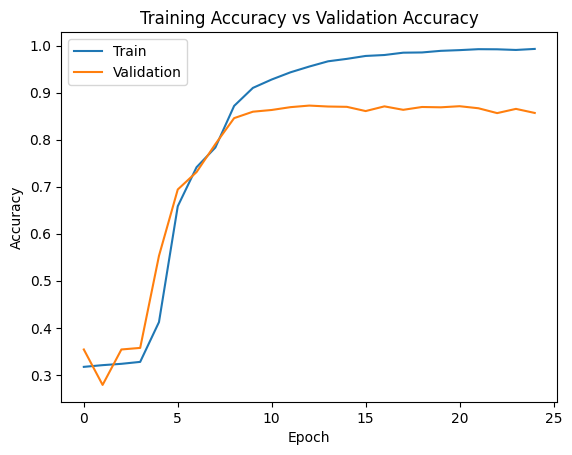

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

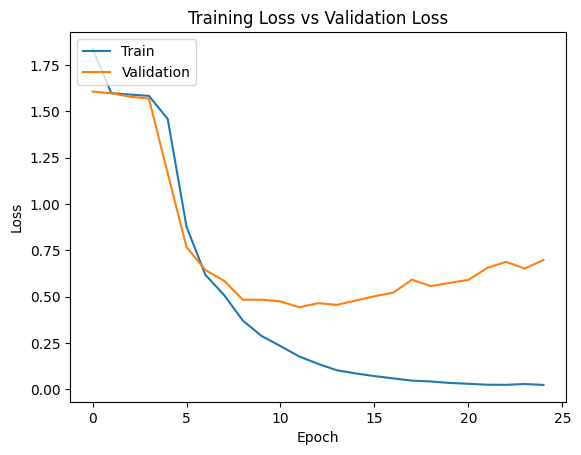

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**5.2 TEST THE MODEL**

In [ ]:
def get_text(text):
    tokenizer3 = Tokenizer()
    tokenizer3.fit_on_texts(text)
    word_index3 = tokenizer3.word_index

    stemmed_wordss = [stemmer.stem(word) for word in word_index3.keys()]

    tokens_list= tokenizer2.texts_to_sequences([stemmed_wordss])[0]

    for i in range(len(tokens_list)):
        for j in range(length_of_longest_sentence-len(tokens_list)):
            tokens_list.append(0)
    return tokens_list


In [ ]:
for _ in range(5):
    random_number = random.randint(0, 1000)
    num_to_predicte = random_number

    test = get_text([test_data['text'][num_to_predicte]])

    test = np.array(test)
    test = test.reshape(1, len(test))

    # Make predictions
    predictions = model.predict(test)

    predicted_class = np.argmax(predictions)
    print()
    print('Random value = ',random_number)
    print("Predicted Class:", predicted_class,labels_dict.get(predicted_class))
    print("Actual Class:", test_data['label'][num_to_predicte])
    print()

1/1 [==============================] - 1s 899ms/step

Random value =  777
Predicted Class: 3 anger
Actual Class: 0

1/1 [==============================] - 0s 34ms/step

Random value =  220
Predicted Class: 1 joy
Actual Class: 1

1/1 [==============================] - 0s 34ms/step

Random value =  555
Predicted Class: 1 joy
Actual Class: 1

1/1 [==============================] - 0s 34ms/step

Random value =  553
Predicted Class: 0 sadness
Actual Class: 0

1/1 [==============================] - 0s 43ms/step

Random value =  518
Predicted Class: 0 sadness
Actual Class: 3



**5.2 CONFUSION MATRIX**

In [ ]:
new_test_data=preprocess_data(test_data)

test_X = [row[0] for row in new_train_data]
test_y = [row[1] for row in new_train_data]

for i in range(len(test_X)):
    for j in range(length_of_longest_sentence-len(test_X[i])):
        test_X[i].append(0)

test_X = np.array(test_X)
test_y = np.array(test_y)

test_y_one_hot = to_categorical(test_y, num_classes=16000)

In [ ]:
y_pred = model.predict(test_X)
y_pred_classes = np.argmax(y_pred, axis=1)

500/500 [==============================] - 42s 83ms/step


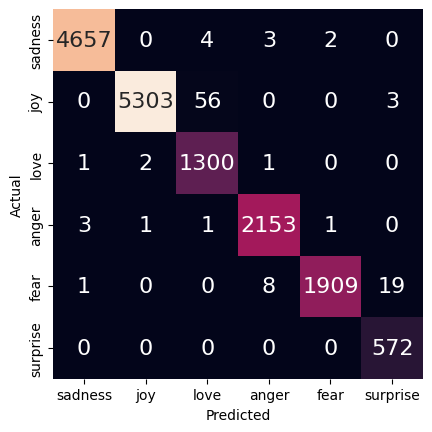

In [ ]:
y_true_labels = np.argmax(test_y_one_hot, axis=1)

labels=['sadness','joy','love','anger','fear','surprise']
#labels = list(set(labels).intersection(set(np.unique(y_true_labels)).union(set(np.unique(y_pred_classes)))))

cm = confusion_matrix(y_true_labels, y_pred_classes)
df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={'size': 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 6)
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.invert_yaxis()
plt.show()
